#1.포켓몬 149종 분류하기
* Train(학습) :  https://www.kaggle.com/datasets/thedagger/pokemon-generation-one

* validation(모의고사) : https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset


{"username":"sangdal","key":"babda6dcee8ac7ebfa02ef064f9e3e16"}

In [ ]:
# !rm -rf /content/.ipynb_checkpoints

In [1]:
import os

In [2]:
# 데이터셋 다운로드
os.environ['KAGGLE_USERNAME'] ='sangdal' # username
os.environ['KAGGLE_KEY'] = 'babda6dcee8ac7ebfa02ef064f9e3e16' # key

In [3]:
# Train 다운로드
!kaggle datasets download -d thedagger/pokemon-generation-one
!unzip -q pokemon-generation-one.zip

100% 2.15G/2.15G [00:19<00:00, 149MB/s]
100% 2.15G/2.15G [00:19<00:00, 121MB/s]


In [4]:
# validation 다운로드
!kaggle datasets download -d hlrhegemony/pokemon-image-dataset
!unzip -q pokemon-image-dataset.zip

100% 57.9M/57.9M [00:00<00:00, 76.6MB/s]
100% 57.9M/57.9M [00:00<00:00, 73.6MB/s]


In [5]:
# 디렉토리 이름 변경 (리눅스 명령어)
# train, validation 으로 이름 변경하기
!mv dataset train

In [6]:
!rm -rf train/dataset

In [7]:
!mv images validation

In [8]:
import os

In [9]:
train_labels = os.listdir('train')
len(train_labels)

149

In [10]:
val_labels = os.listdir('validation')
len(val_labels)

898

In [11]:
# 중복만 남겨놓고 validation지우기
import shutil

In [12]:
for val_label in val_labels :
  if val_label not in train_labels:
    shutil.rmtree(os.path.join('validation', val_label))

val_labels = os.listdir('validation')
len(val_labels)

147

In [13]:
for train_label in train_labels :
  if train_label not in val_labels:
    print(train_label)
    os.makedirs(os.path.join('validation', train_label), exist_ok=True)

val_labels = os.listdir('validation')
len(val_labels)

MrMime
Farfetchd


149

파오리 :
https://www.drawingtutorials101.com/drawing-tutorials/Anime-and-Manga/Pokemon/farfetch-d/how-to-draw-Farfetchd-from-Pokemon-step-0.png

마임맨:
https://files.slack.com/files-tmb/T026S7PEVA7-F05DG7UHBFC-29f8bdad44/mr.-mime-pokemon-png-free-download_720.png

In [ ]:
# 이미지 다운받기 (파오리)
# !wget -q https://www.drawingtutorials101.com/drawing-tutorials/Anime-and-Manga/Pokemon/farfetch-d/how-to-draw-Farfetchd-from-Pokemon-step-0.png

In [ ]:
# 이미지 다운받기 (마임맨) png깨짐
# !wget -q https://files.slack.com/files-tmb/T026S7PEVA7-F05DG7UHBFC-29f8bdad44/mr.-mime-pokemon-png-free-download_720.png

In [14]:
# 패키지 로드(import)
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F

In [15]:
# GPU사용하기

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [16]:
# transforms.Compose를 사용하여 사이즈, Affine, RandomHrizontalFlip, ToTensor 변환.....
# 이미지 증감 기법과 tensor 변경

data_transforms = {
    'train' : transforms.Compose([                              # Compose 아래 내용을 한꺼번에 실행시켜라
        transforms.Resize((224,224)),                           # 224,224사이즈로 변경 하기
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), # 랜덤하게 10개를 뽑아서 규모는 +-20%
        transforms.RandomHorizontalFlip(),                      # 이미지 반전시킴
        transforms.ToTensor()                                   # 텐서 형태로 바꿔라
    ]),
    'validation' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
}

# 데이터셋 만들기
image_datasets = {
    'train' : datasets.ImageFolder('/content/train', data_transforms['train']), #차원이 올라가서 안써준다.
    'validation' : datasets.ImageFolder('/content/validation', data_transforms['validation'])
}
# 데이터로더 (bathch size를 32) 만들기
dataloaders = {
    'train' : DataLoader(
        image_datasets['train'],
        batch_size = 32,
        shuffle = True
    ),
    'validation' : DataLoader(
        image_datasets['validation'],
        batch_size = 32,
        shuffle = False
    )
}

print(len(image_datasets['train']), len(image_datasets['validation']))

10657 663


In [ ]:
!rm -r /content/validation/.ipynb_checkpoints

rm: cannot remove '/content/validation/.ipynb_checkpoints': No such file or directory


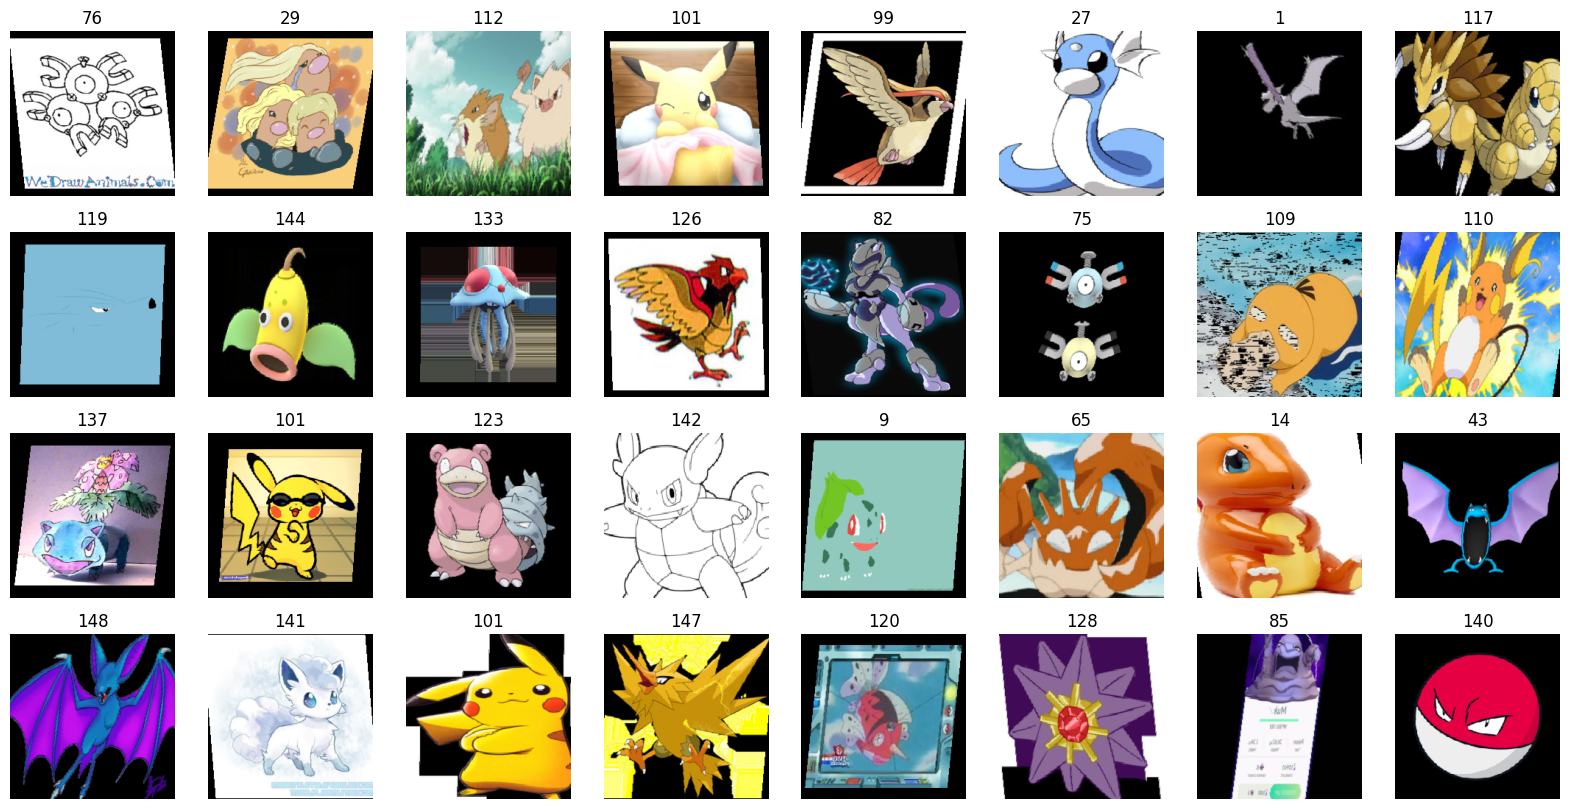

In [17]:
# 1개의 batch만큼 이미지를 출력

imgs, labels = next(iter(dataloaders['train']))
fig, axes = plt.subplots(4,8,figsize=(20,10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
  ax.set_title(label.item())
  ax.imshow(img.permute(1,2,0))
  ax.axis('off')

In [18]:
# 클래스 이름 확인하기
# image_datasets['train'].classes # 이름 전체뽑기
image_datasets['train'].classes[141]

'Vulpix'

In [19]:
# 사전 학습된 EfficientNetB4 모델 사용하기
model = models.efficientnet_b4(weights = 'IMAGENET1K_V1').to(device)
print(model)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 86.1MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [20]:
# 모델 만들기
for param in model.parameters():
  param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(1792, 512),
    nn.ReLU(),
    nn.Linear(512, 149)
).to(device)

print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
# 학습시키기

optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)

epochs = 10

for epoch in range(epochs):
  for phase in ['train', 'validation']:
    if phase == 'train':
      model.train()
    else :
      model.eval()


    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders[phase]:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_pred = model(x_batch)

      loss = nn.CrossEntropyLoss()(y_pred, y_batch)

      if phase == 'train':
        optimizer.zero_grad()
        loss.backward() #역전파
        optimizer.step()#기울기초기화

      # 배치단위 loss 저장
      sum_losses = sum_losses + loss.item()

      # 배치단위 정확도 저장
      y_prob = nn.Softmax(1)(y_pred)#  Softmax(1): Softmax 함수가 두 번째 차원(axis)에 대해 작동함.
      y_pred_index = torch.argmax(y_prob, axis=1)
      # argmax(): 가장 큰 확률을 가지는 클래스의 인덱스를 추출.
      # axis=1: 두 번째 차원에서 최댓값을 찾음.

      acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
      # 정확도(acc): 실제레이블(y_batch)과 예측결과(y_pred_index)를 비교하여 예측된 데이터 포인트의
      # 비율을 계산. 레이블과 예측 결과를 비교한 결과는 Boolean형태의 텐서임.

      sum_accs = sum_accs + acc.item()

    avg_loss = sum_losses / len(dataloaders[phase])
    avg_acc = sum_accs / len(dataloaders[phase])


    print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train     : Epoch    1/10, Loss: 3.3546, Accuracy: 29.70%
validation: Epoch    1/10, Loss: 1.4875, Accuracy: 69.14%


In [ ]:
# 학습된 모델파일 저장하기
torch.save(model.state_dict(), 'model.h5')

In [ ]:
# 빈모델 생성하기
model = models.efficientnet_b4().to(device)

# 모델 만들기
for param in model.parameters():
  param.requires_grad = False
# 모델 수정하기
model.classifier = nn.Sequential(
    nn.Linear(1792, 512),
    nn.ReLU(),
    nn.Linear(512, 149)
).to(device)

# 빈 모델에 저장된 모델 불러오기
model.load_state_dict(torch.load('model.h5'))


In [ ]:
# 테스트(validation에 있는 2종의 포켓몬을 통해 분류 테스트 확률 출력해보기 )

# 테스트 해보기
from PIL import Image

# 학습용(train)말고  validation안에 있는 이미지를 사용한다.
img1 = Image.open('/content/validation/Butterfree/0.jpg')
img2 = Image.open('/content/validation/Cloyster/1.jpg')

# 어떤 사진인지 확인해보기(안해도 상관은 없음)
fig, axes = plt.subplots(1,2,figsize=(12,6))

axes[0].imshow(img1)
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].axis('off')
plt.show()


In [ ]:
# 테스트를 위해 사이즈 변경하기
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)

print(img1_input.shape)
print(img2_input.shape)

In [ ]:
test_batch = torch.stack([img1_input, img2_input]) # stack(): 붙여주는 함수
test_batch = test_batch.to(device)
test_batch.shape  # img 2개가 붙어 [2,3,224,224]로 변경됨.

In [ ]:
y_pred = model(test_batch)
y_pred

In [ ]:
y_prod = nn.Softmax(1)(y_pred)
y_prod

In [ ]:
probs, indices = torch.topk(y_prob, k=3, axis = -1)# (2,3,224,224)에서 axis=-1은 224이다.

# k=3은 가장 높은것에서부터 3개만 꼽는다는 의미. # probs=확률값, indices=인덱스값
probs = probs.cpu().data.numpy()
indices = indices.cpu().data.numpy()
print(probs)
print(indices)

In [ ]:
# 화면에 띄우기
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('{:.2f}% {}, {:.2f}% {}, {:.2f}% {}'.format(
    probs[0, 0] * 100, image_datasets['validation'].classes[indices[0, 0]],
    probs[0, 1] * 100, image_datasets['validation'].classes[indices[0, 1]],
    probs[0, 2] * 100, image_datasets['validation'].classes[indices[0, 2]]
))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].set_title('{:.2f}% {}, {:.2f}% {}, {:.2f}% {}'.format(
    probs[1, 0] * 100, image_datasets['validation'].classes[indices[1, 0]],
    probs[1, 1] * 100, image_datasets['validation'].classes[indices[1, 1]],
    probs[1, 2] * 100, image_datasets['validation'].classes[indices[1, 2]]
))
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()